# Importações

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import sys
sys.path.insert(1, '../predict_stock_mvp/pre_train/')
import load_data
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from gluonts.dataset.pandas import PandasDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import pickle

In [2]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean

from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import make_evaluation_predictions, Evaluator

# Carregando dados

In [3]:
data = load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [4]:
data.head()

NUMERO_REGISTRO_PRODUTO  IDENTIFICADOR_DO_ITEM NOME_PRODUTO  \
0                 10277002            25991014035     BILAGOGO   
1                 10277002            25991014035     BILAGOGO   
2                 10277002            25991014035     BILAGOGO   
3                 10277002            25991014035     BILAGOGO   
4                 10277002            25991014035     BILAGOGO   

  DATA_DE_CONSUMO  QUANTIDADE_SAIDA  
0      2020-02-29                21  
1      2020-03-31                18  
2      2020-04-30                56  
3      2020-05-31                 0  
4      2020-06-30                21

# Criando teste de pipeline para DeepAr
https://kekayan.medium.com/forecasting-with-deepar-for-busy-people-ed67f9d9a00d

## Pré processamento

In [5]:
data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]

In [6]:
data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")

C:\Users\anton\AppData\Local\Temp\ipykernel_10756\405872292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


In [7]:
data_para_processamento.head()

QUANTIDADE_SAIDA  NUMERO_REGISTRO_PRODUTO
DATA_DE_CONSUMO                                           
2020-02-29                     21                 10277002
2020-03-31                     18                 10277002
2020-04-30                     56                 10277002
2020-05-31                      0                 10277002
2020-06-30                     21                 10277002

In [8]:
prediction_length = 6

data_para_processamento_new = pd.DataFrame(None, columns = data_para_processamento.columns)
for n in tqdm(data_para_processamento.NUMERO_REGISTRO_PRODUTO.unique()):
    frame_train = data_para_processamento.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iloc[:-prediction_length]
    data_para_processamento_new = pd.concat([data_para_processamento_new, frame_train])

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:12<00:00, 161.82it/s]


In [9]:
train = PandasDataset.from_long_dataframe(data_para_processamento_new, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")

## Treinamento

In [10]:
callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]


estimator = DeepAREstimator(
    freq="M",
    prediction_length=prediction_length,
    context_length=16,
    num_layers = 2,
    num_cells = 50,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=10,
                    callbacks=callbacks))

predictor = estimator.train(train)

100%|████████████████████████████████████████████████| 50/50 [00:01<00:00, 27.62it/s, epoch=10/10, avg_epoch_loss=4.13]


## Predição

In [11]:
import sys
sys.path.insert(1, '../predict_stock_mvp/pre_train/')
import load_data

In [12]:
table_test = load_data.conect_data.load_table('../../data/data_processed/', 'processed.predict', 'csv', sep=",")

In [13]:
table_test.head(24)

NUMERO_REGISTRO_PRODUTO DATA_DE_CONSUMO  QUANTIDADE_SAIDA  \
0                  10277002      2020-02-29                21   
1                  10277002      2020-03-31                18   
2                  10277002      2020-04-30                56   
3                  10277002      2020-05-31                 0   
4                  10277002      2020-06-30                21   
5                  10277002      2020-07-31                 8   
6                  10277002      2020-08-31                30   
7                  10277002      2020-09-30                17   
8                  10277002      2020-10-31                16   
9                  10277002      2020-11-30                 5   
10                 10277002      2020-12-31                 1   
11                 10277002      2021-01-31                 0   
12                 10277002      2021-02-28                28   
13                 10277002      2021-03-31                20   
14                 10277002      2021-04-30                 4   
15                 10277002      2021-05-31                21   
16                 10277002      2021-06-30                48   
17                 10277002      2021-07-31                19   
18                 10277002      2021-08-31                 1   
19                 10277002      2021-09-30                 2   
20                 10277002      2021-10-31                29   
21                 10277002      2021-11-30                 1   
22                 10277002      2021-12-31                12   
23                 10277002      2022-01-31                36   

    PREDICAO_MEDIA_MOVEL  
0                    NaN  
1                    NaN  
2                    NaN  
3              31.666667  
4              24.666667  
5              25.666667  
6               9.666667  
7              19.666667  
8              18.333333  
9              21.000000  
10             12.666667  
11              7.333333  
12              2.000000  
13              9.666667  
14             16.000000  
15             17.333333  
16             15.000000  
17             24.333333  
18             29.333333  
19             22.666667  
20              7.333333  
21             10.666667  
22             10.666667  
23             14.000000

In [46]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

In [51]:
forecast_entry.quantile(0.5)

array([19.865072, 21.76167 , 19.947989, 21.3107  , 27.062183, 23.18061 ],
      dtype=float32)

In [55]:
forecasts[0].quantile(0.5).tolist()

[19.86507225036621,
 21.761669158935547,
 19.947988510131836,
 21.310699462890625,
 27.062183380126953,
 23.18061065673828]

In [56]:
for n in forecasts:
    print(n.samples)

[[ 46.299095    42.08834     69.74988     48.13194     54.438828
   53.303448  ]
 [ -2.5332663   13.786792    26.510468     6.2413445   53.063972
   17.297132  ]
 [ 19.865072    15.404608     2.6535888   24.11648      7.6083536
   38.01675   ]
 [ 24.649145    19.006317     8.172534    54.770382    29.040813
   43.256485  ]
 [ -5.6206822    3.2976966   17.79441     17.721989   -52.848022
   66.0831    ]
 [ 72.70058     29.30608     24.021343     9.11601     28.641048
   21.60467   ]
 [ 53.96533     21.882036    -5.6736565   34.289127    -7.8307858
   32.37008   ]
 [ 25.475374     7.3129654   21.764444    14.493234    56.330338
   53.874645  ]
 [ 30.096508    52.971684    31.078289   -19.912073    32.374336
   31.16494   ]
 [ 30.505243    33.299942     7.562998    22.725252    26.580193
   28.578745  ]
 [ 32.771114    53.385223    11.456809    32.975643    33.217525
   34.835358  ]
 [ 25.115553    12.423139    16.303596    16.663113    24.38712
   34.419857  ]
 [ 44.87715     41.515614  

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



[[ 3.34417000e+01 -2.29430828e+01  7.46991425e+01  2.44883575e+01
   6.21891785e+01  4.59918671e+01]
 [ 4.62589417e+01  3.57274551e+01  2.82005367e+01  1.44472485e+01
   2.76339283e+01 -4.99944954e+01]
 [ 8.75614405e-01  3.53022919e+01  2.12100086e+01  1.95593719e+01
   1.63252640e+01  1.34263670e+00]
 [ 4.31336937e+01  2.42091675e+01  2.49061012e+01  8.31320572e+00
   3.14361057e+01  5.29152918e+00]
 [ 3.53270683e+01  9.40088558e+00 -1.35406857e+01  1.59476194e+01
   2.28205338e+01 -2.45595264e+00]
 [ 1.73688889e+01  1.52731285e+01  9.04526424e+00  4.75065155e+01
  -2.55818691e+01  4.16811676e+01]
 [ 2.95991936e+01  4.03533249e+01  2.56457081e+01  2.30721760e+01
   2.81731472e+01  4.84056044e+00]
 [ 4.00623131e+01  2.96449547e+01  4.66042099e+01  7.01744652e+00
   2.57833710e+01  4.96905289e+01]
 [ 2.30915594e+00  9.80625248e+00  8.31109047e+00  2.27074947e+01
   1.74322433e+01  4.68044853e+01]
 [-4.47417183e+01  5.71367741e-02  5.19526367e+01  8.29702473e+00
   2.89440022e+01  3.5539

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [57]:
for n in table_test.DATA_DE_CONSUMO:
    if n.find(str(forecasts[0].start_date)) == 0:
        filtro = n
        break

In [67]:
data_input = table_test.query(f"DATA_DE_CONSUMO >= '{filtro}'")
lista = []

contador_itens = 0
for n in tqdm(data_input.NUMERO_REGISTRO_PRODUTO.unique()):
    lista_de_predicao = forecasts[contador_itens]
    contador_itens = contador_itens + 1
    
    contador_valores = 0
    for idx, linha in data_input.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iterrows():
        lista.append(lista_de_predicao.quantile(0.5).tolist()[contador_valores])
        contador_valores = contador_valores + 1
        
data_input["PREDICAO_DEEPAR"] = lista

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 650.27it/s]
C:\Users\anton\AppData\Local\Temp\ipykernel_10756\651547270.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input["PREDICAO_DEEPAR"] = lista


In [68]:
data_input.head(6)

NUMERO_REGISTRO_PRODUTO DATA_DE_CONSUMO  QUANTIDADE_SAIDA  \
18                 10277002      2021-08-31                 1   
19                 10277002      2021-09-30                 2   
20                 10277002      2021-10-31                29   
21                 10277002      2021-11-30                 1   
22                 10277002      2021-12-31                12   
23                 10277002      2022-01-31                36   

    PREDICAO_MEDIA_MOVEL  PREDICAO_DEEPAR  
18             29.333333        19.865072  
19             22.666667        21.761669  
20              7.333333        19.947989  
21             10.666667        21.310699  
22             10.666667        27.062183  
23             14.000000        23.180611

In [69]:
forecasts[0].quantile(0.5).tolist()

[19.86507225036621,
 21.761669158935547,
 19.947988510131836,
 21.310699462890625,
 27.062183380126953,
 23.18061065673828]

In [70]:
data_input.tail(6)

NUMERO_REGISTRO_PRODUTO DATA_DE_CONSUMO  QUANTIDADE_SAIDA  \
47994                996640035      2021-08-31                 4   
47995                996640035      2021-09-30                81   
47996                996640035      2021-10-31                21   
47997                996640035      2021-11-30                21   
47998                996640035      2021-12-31                 0   
47999                996640035      2022-01-31                 6   

       PREDICAO_MEDIA_MOVEL  PREDICAO_DEEPAR  
47994             21.000000        17.084833  
47995             10.666667        23.141647  
47996             36.000000        21.158909  
47997             35.333333        22.495544  
47998             41.000000        24.233715  
47999             14.000000        24.429508

In [71]:
forecasts[-1].quantile(0.5).tolist()

[17.0848331451416,
 23.141647338867188,
 21.15890884399414,
 22.49554443359375,
 24.233715057373047,
 24.429508209228516]

In [72]:
table_predict = pd.concat([data_input,table_test.query(f"DATA_DE_CONSUMO < '{filtro}'")]).sort_values("DATA_DE_CONSUMO")

In [73]:
table_predict.query("NUMERO_REGISTRO_PRODUTO == 10277002")

NUMERO_REGISTRO_PRODUTO DATA_DE_CONSUMO  QUANTIDADE_SAIDA  \
0                  10277002      2020-02-29                21   
1                  10277002      2020-03-31                18   
2                  10277002      2020-04-30                56   
3                  10277002      2020-05-31                 0   
4                  10277002      2020-06-30                21   
5                  10277002      2020-07-31                 8   
6                  10277002      2020-08-31                30   
7                  10277002      2020-09-30                17   
8                  10277002      2020-10-31                16   
9                  10277002      2020-11-30                 5   
10                 10277002      2020-12-31                 1   
11                 10277002      2021-01-31                 0   
12                 10277002      2021-02-28                28   
13                 10277002      2021-03-31                20   
14                 10277002      2021-04-30                 4   
15                 10277002      2021-05-31                21   
16                 10277002      2021-06-30                48   
17                 10277002      2021-07-31                19   
18                 10277002      2021-08-31                 1   
19                 10277002      2021-09-30                 2   
20                 10277002      2021-10-31                29   
21                 10277002      2021-11-30                 1   
22                 10277002      2021-12-31                12   
23                 10277002      2022-01-31                36   

    PREDICAO_MEDIA_MOVEL  PREDICAO_DEEPAR  
0                    NaN              NaN  
1                    NaN              NaN  
2                    NaN              NaN  
3              31.666667              NaN  
4              24.666667              NaN  
5              25.666667              NaN  
6               9.666667              NaN  
7              19.666667              NaN  
8              18.333333              NaN  
9              21.000000              NaN  
10             12.666667              NaN  
11              7.333333              NaN  
12              2.000000              NaN  
13              9.666667              NaN  
14             16.000000              NaN  
15             17.333333              NaN  
16             15.000000              NaN  
17             24.333333              NaN  
18             29.333333        19.865072  
19             22.666667        21.761669  
20              7.333333        19.947989  
21             10.666667        21.310699  
22             10.666667        27.062183  
23             14.000000        23.180611

## Avaliação

In [77]:
evaluator = Evaluator(quantiles=[0.5])
agg_metrics, item_metrics = evaluator(tss, forecasts, num_series=len(test))

Running evaluation: 100%|█████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 365.72it/s]


In [78]:
print(agg_metrics["MSE"])
print(agg_metrics["RMSE"])
print(agg_metrics["abs_target_mean"])

263.1649548781713
16.222359719787107
19.2755


In [80]:
item_metrics.head()

item_id         MSE  abs_error  abs_target_sum  abs_target_mean  \
0   10277002  261.055705  95.871025            81.0        13.500000   
1  100020070  280.332743  83.232033           139.0        23.166667   
2  100020082   82.107290  45.550461           104.0        17.333333   
3  100020086  142.063090  51.643944           138.0        23.000000   
4  100020095  157.347626  65.324928            88.0        14.666667   

   seasonal_error      MASE      MAPE     sMAPE        ND      MSIS  \
0       20.000000  0.798925  8.496670  1.144435  1.183593  3.876535   
1       30.000000  0.462400  2.473535  0.695436  0.598792  2.808570   
2       16.666667  0.455505  0.855658  0.474140  0.437985  4.029156   
3       19.166667  0.449078  4.229879  0.479372  0.374231  4.002690   
4       18.333333  0.593863  1.356713  0.705637  0.742329  4.518442   

   QuantileLoss[0.5]  Coverage[0.5]  
0          95.871025       0.666667  
1          83.232029       0.500000  
2          45.550463       0.666667  
3          51.643946       0.500000  
4          65.324926       0.666667

In [81]:
forecasts[0].samples.shape

(100, 6)

In [82]:
forecasts[0]

gluonts.model.forecast.SampleForecast(info=None, item_id="10277002", samples=numpy.array([[46.299095153808594, 42.088340759277344, 69.7498779296875, 48.13193893432617, 54.43882751464844, 53.30344772338867], [-2.533266305923462, 13.786791801452637, 26.510467529296875, 6.241344451904297, 53.06397247314453, 17.29713249206543], [19.86507225036621, 15.404607772827148, 2.6535887718200684, 24.116479873657227, 7.608353614807129, 38.01675033569336], [24.649145126342773, 19.006317138671875, 8.172533988952637, 54.770381927490234, 29.040813446044922, 43.25648498535156], [-5.620682239532471, 3.297696590423584, 17.794410705566406, 17.721988677978516, -52.8480224609375, 66.08309936523438], [72.70057678222656, 29.306079864501953, 24.021343231201172, 9.116009712219238, 28.641048431396484, 21.60466957092285], [53.965328216552734, 21.882036209106445, -5.673656463623047, 34.289127349853516, -7.830785751342773, 32.370079040527344], [25.475374221801758, 7.312965393066406, 21.76444435119629, 14.4932336807250

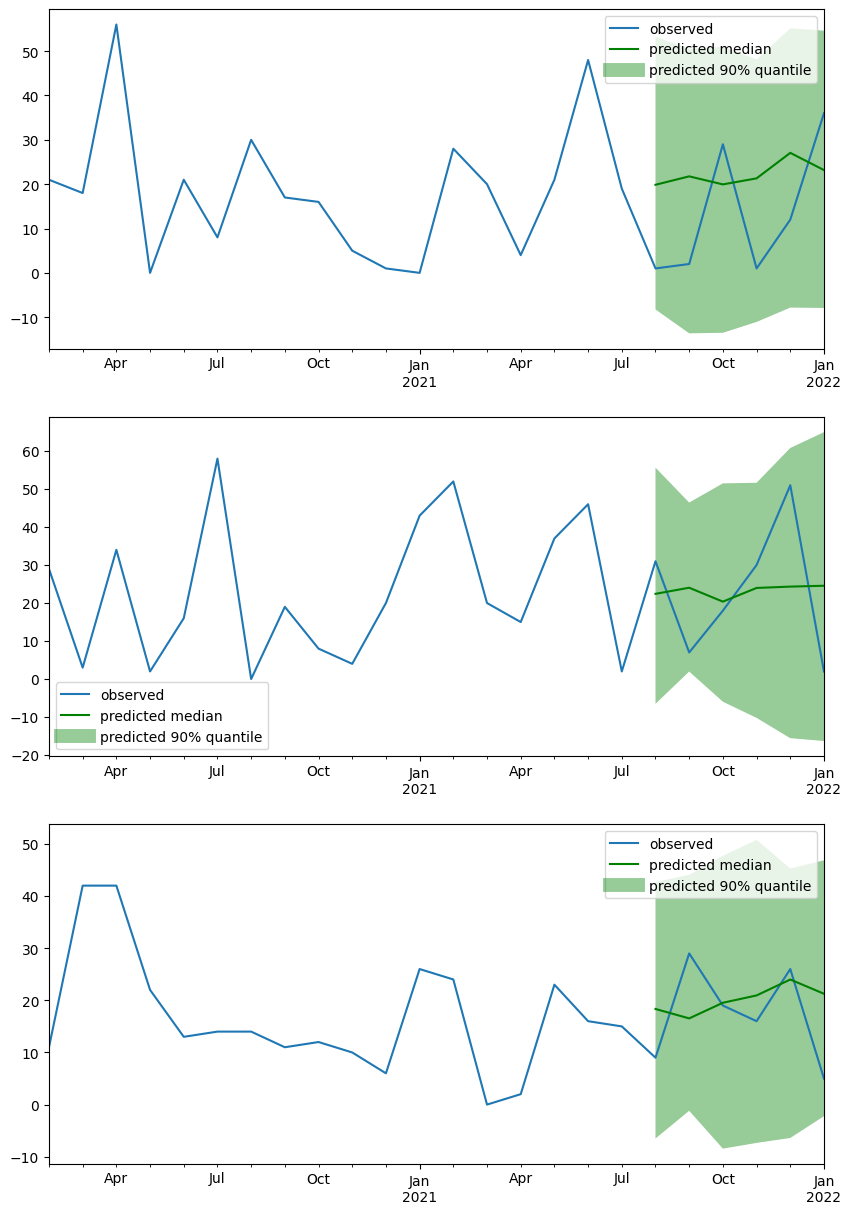

In [83]:
from matplotlib import pyplot as plt

n_plot = 3
indices = [0,1,2]
fig, axes = plt.subplots(n_plot, 1, figsize=(10, n_plot * 5))
for index, ax in zip(indices, axes):
    tss[index][-4 * prediction_length :].plot(ax=ax)
    plt.sca(ax)
    forecasts[index].plot(prediction_intervals=[90.0], color="g")
    plt.legend(["observed", "predicted median", "predicted 90% quantile"])

# Criando classes para pipeline em DeepAr

## Pré processamento

In [11]:
class pre_process:
    
    def pre_process_deepar(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None), prediction_length = 6):
        data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]
        data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
        data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")
        
        data_para_processamento_new = pd.DataFrame(None, columns = data_para_processamento.columns)
        for n in data_para_processamento.NUMERO_REGISTRO_PRODUTO.unique():
            frame_train = data_para_processamento.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iloc[:-prediction_length]
            data_para_processamento_new = pd.concat([data_para_processamento_new, frame_train])
            
        train = PandasDataset.from_long_dataframe(data_para_processamento_new, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        
        return train, test
    
    def pre_process_deepar_predict(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)):
        data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]
        data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
        data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")
        
        test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        
        return test

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [13]:
train, test = pre_process.pre_process_deepar()

C:\Users\anton\AppData\Local\Temp\ipykernel_7736\3993147561.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


In [16]:
serie_predict = pre_process.pre_process_deepar_predict()

C:\Users\anton\AppData\Local\Temp\ipykernel_7736\3993147561.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


## Treinamento

In [24]:
class train_model:
    
    def train_deepAR(data_train,
                     freq="M",
                     prediction_length=6,
                     context_length=16,
                     num_layers=2,
                     num_cells=50,
                     learning_rate=0.01,
                     epochs=10):
        
        callbacks = [LearningRateReduction(objective="min", patience=10, base_lr=1e-3, decay_factor=0.5),
                        ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))]

        estimator = DeepAREstimator(freq=freq,
                                    prediction_length=prediction_length,
                                    context_length=context_length,
                                    num_layers = num_layers,
                                    num_cells = num_cells,
                                    trainer=Trainer(#ctx = mx.context.gpu(),
                                                    epochs=epochs,
                                                    learning_rate=learning_rate,
                                                    callbacks=callbacks))

        predictor = estimator.train(data_train)
        pd.to_pickle(predictor,'../../data/models/deepAR_model.pickle' )
        return predictor

In [25]:
train_model.train_deepAR(train)

100%|████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.07it/s, epoch=10/10, avg_epoch_loss=4.16]


## Predição

In [48]:
import sys
sys.path.insert(1, '../pre_train/')
import load_data

class metods_predict:
    """
    Classe que contém métodos para realizar as predições, tanto dos modelos quanto das outras técnicas para comparação.
    """
    
    def predict_model_deepAR(data_test, data_predict, name_predictor):
        predictor = pd.read_pickle(f"../../data/models/{name_predictor}.pickle")
        
        forecast_it, ts_it = make_evaluation_predictions(dataset=data_test, predictor=predictor, num_samples=100)
        forecasts = list(forecast_it)
        tss = list(ts_it)
        
        for n in data_predict.DATA_DE_CONSUMO:
            if n.find(str(forecasts[0].start_date)) == 0:
                filtro = n
                break
                
        data_input = data_predict.query(f"DATA_DE_CONSUMO >= '{filtro}'")
        lista = []
        contador_itens = 0
        for n in tqdm(data_input.NUMERO_REGISTRO_PRODUTO.unique()):
            lista_de_predicao = forecasts[contador_itens]
            contador_itens = contador_itens + 1
            contador_valores = 0
            for idx, linha in data_input.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iterrows():
                lista.append(lista_de_predicao.quantile(0.5).tolist()[contador_valores])
                contador_valores = contador_valores + 1
        data_input["PREDICAO_DEEPAR"] = lista
        
        table_predict = pd.concat([data_input,data_predict.query(f"DATA_DE_CONSUMO < '{filtro}'")]).sort_values(by=["NUMERO_REGISTRO_PRODUTO",
                                                                                                                  "DATA_DE_CONSUMO"])
        load_data.conect_data.save_table(table_predict, '../../data/data_processed/', 'processed.predict', 'csv')
        return table_predict
    
    def predict_mean(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None)):
        """
        Método que calcula a predição baseado na média móvel.

        Args:
            data (Dataframe, optional): Tabela de input com valores para calcular a curva ABC. Defaults to load_data.conect_data.load_table('../../../data/data_ingestion/', 'ingestion.itens_input_mvp', 'csv', sep=None).
        """
        data_predict_media_movel = data[["NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO","QUANTIDADE_SAIDA"]]
        
        predict_media = []
        for item in data_predict_media_movel["NUMERO_REGISTRO_PRODUTO"].unique():
            serie_itens = data_predict_media_movel.query(f"NUMERO_REGISTRO_PRODUTO == {item}")
            media_movel = list(serie_itens.QUANTIDADE_SAIDA.shift(1).rolling(3).mean())
            for n in media_movel[:]:
                predict_media.append(n)
                
        data_predict_media_movel["PREDICAO_MEDIA_MOVEL"] = predict_media
        
        load_data.conect_data.save_table(data_predict_media_movel, '../../../data/data_processed/', 'processed.predict', 'csv')

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [29]:
def pre_process_deepar(data=load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None), prediction_length = 6):
        """
        Função para pré processar, em treinamento e teste, os dados da série temporal no formato de input do modelo deepAR.

        Args:
            data (Dataframe, optional): Tabela de output com valores para pré processar. Defaults to load_data.conect_data.load_table('../../data/data_ingestion/', 'ingestion.itens_output_mvp', 'csv', sep=None).
            prediction_length (int, optional): Meses que o modelo irá prever. Defaults to 6.

        Returns:
            Dataframe: Retorna dois dataframes, um de trainamento e outro de teste para inputar no modelo.
        """
        data_para_processamento = data[["QUANTIDADE_SAIDA","NUMERO_REGISTRO_PRODUTO","DATA_DE_CONSUMO"]]
        data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())
        data_para_processamento = data_para_processamento.set_index("DATA_DE_CONSUMO")
        
        data_para_processamento_new = pd.DataFrame(None, columns = data_para_processamento.columns)
        for n in data_para_processamento.NUMERO_REGISTRO_PRODUTO.unique():
            frame_train = data_para_processamento.query(f"NUMERO_REGISTRO_PRODUTO == {n}").iloc[:-prediction_length]
            data_para_processamento_new = pd.concat([data_para_processamento_new, frame_train])
            
        train = PandasDataset.from_long_dataframe(data_para_processamento_new, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        test = PandasDataset.from_long_dataframe(data_para_processamento, target="QUANTIDADE_SAIDA", item_id="NUMERO_REGISTRO_PRODUTO")
        
        return train, test

In [31]:
train, test = pre_process_deepar()

C:\Users\anton\AppData\Local\Temp\ipykernel_15840\666432197.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_para_processamento["DATA_DE_CONSUMO"] = data_para_processamento.DATA_DE_CONSUMO.apply(lambda linha: datetime.strptime(linha, '%Y-%m-%d').date())


In [50]:
save_predict = load_data.conect_data.load_table('../../data/data_processed/', 'processed.predict', 'csv', sep=None)

../predict_stock_mvp/pre_train\load_data.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(f'{location_table}/{name_table}.{type_table}', encoding=encoding, sep=sep)


In [53]:
load_data.conect_data.save_table(save_predict.drop("PREDICAO_DEEPAR", axis=1), '../../data/data_processed/', 'processed.predict', 'csv')

'save_sucess'

In [49]:
metods_predict.predict_model_deepAR(test,save_predict,"deepAR_model")

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 634.45it/s]
C:\Users\anton\AppData\Local\Temp\ipykernel_15840\947679688.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input["PREDICAO_DEEPAR"] = lista


NUMERO_REGISTRO_PRODUTO DATA_DE_CONSUMO  QUANTIDADE_SAIDA  \
0                     10277002      2020-02-29                21   
1                     10277002      2020-03-31                18   
2                     10277002      2020-04-30                56   
3                     10277002      2020-05-31                 0   
4                     10277002      2020-06-30                21   
...                        ...             ...               ...   
47995                996640035      2021-09-30                81   
47996                996640035      2021-10-31                21   
47997                996640035      2021-11-30                21   
47998                996640035      2021-12-31                 0   
47999                996640035      2022-01-31                 6   

       PREDICAO_MEDIA_MOVEL  PREDICAO_DEEPAR  
0                       NaN              NaN  
1                       NaN              NaN  
2                       NaN              NaN  
3                 31.666667              NaN  
4                 24.666667              NaN  
...                     ...              ...  
47995             10.666667        22.325596  
47996             36.000000        21.189375  
47997             35.333333        21.839285  
47998             41.000000        21.779936  
47999             14.000000        18.343124  

[48000 rows x 5 columns]

## Avaliação